# Predicting Success: Machine Learning Models for CBT Outcomes

# Introduction

This study aims to utilise machine learning techniques to predict the likelihood of success in Cognitive Behavioral Therapy (CBT) using data. The dataset encompasses various demographic, treatment-related, and psychological assessment variables, offering insights into patient profiles and treatment outcomes. By leveraging various analytical skills, predictive models will aid in revealing the success probability for CBT in individual patients.

Contents

1.   Walk through
2.   Traditional Machine Learning
3.   Large Language Model fine-tuning




In [ ]:
from google.colab import drive
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

drive.mount('/content/drive')
notebook_path = '/content/drive/MyDrive/Colab Notebooks/'
sys.path.append(notebook_path)
import cleaning_functions as cleanf
import eda_functions as edaf
import preparation_functions as prepf
import modelling_functions as modelf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Machine Learning

## Loading

### Libraries

In [ ]:
# preprocessing
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# eda
import seaborn as sns
from scipy import stats

# processing
from sklearn.preprocessing import MinMaxScaler # normalisation
from sklearn.preprocessing import Normalizer # works on rows not features
from sklearn.preprocessing import StandardScaler # standardisation

from statsmodels.imputation.mice import MICEData
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # MICE (returning single rather than multiple)

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2 # neg values

# modelling
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

### Data Processing

In [ ]:
# create different processed datasets
data, raw_df = cleanf.load_data()
data = cleanf.Clean_Data(data)

prep1_df = prepf.Prepare_Data(
    df=data,
    quasi_thresh=0.995,
    corr_thresh=0.95,
    load_matrices=True,
    col_thresh=0.5,
    row_thresh=0.5,
    scale_method='normalise',
    imputation_method='iterative',
    #n_neighbours=3,
    max_iter=10,
    k_features=150)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Fine-Tuning

Hyperparameter-Tuning: Round 1

In [ ]:
param_grid1 = dict(
    FS__threshold = ["mean", "median"],
    #FS__n_features_to_select = [10, 15],
    classifier__n_estimators = [200, 400, 500],
    classifier__max_depth = [3, 5],
    classifier__learning_rate = [0.01, 0.1, 0.5],
    classifier__subsample = [0.5, 0.8],
    classifier__colsample_bytree = [0.5, 0.8])

xgb_spec1 = {
    'df': prep1_df,
    'target': 'ReliableRecovery',
    'selector': 'SelectFromModel',
    #'selector': 'RFE',
    'param_grid': param_grid1,
    'outer_k': 10,
    'inner_k': 10}

xgb_model1 = modelf.XGBoost_ModelSelection(**xgb_spec1)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Inner CV accuracy: 0.6438095238095236
Number of selected features 128
Selected features ['Item82', 'Item156', 'Item81', 'Gender', 'Item151', 'Item57', 'EthnicCodeShort', 'Item125', 'Item90', 'Total16', 'Item115', 'Item91', 'AgeAtReferralRequest', 'Item85', 'Item56', 'Item109', 'Threshold5', 'Total15', 'Item186', 'Item86', 'Item16', 'Item9', 'CareContacts', 'Item2', 'Item195', 'Item11', 'CaseID', 'Item19', 'Item83', 'Item13', 'Item32', 'Item210', 'TherapistID', 'EthnicCode', 'Total17', 'Item23', 'Total18', 'Item179', 'Item134', 'Item30', 'Item168', 'Item135', 'DateOfQuestionnaire', 'Item73', 'Item221', 'Total9', 'ClientID', 'DaystoAssessment', 'Item53', 'Item197', 'Item62', 'DaystoTreatment', 'Item114', 'Item167', 'Item181', 'Item140', 'Treated', 'Item4', 'Item198', 'Item120', 'Item188', 'Total1', 'Item174', 'Item145', 'Item219', 'Item25', 'Item142', 'Item84', 'Item161', 'Total14', 'Item17', 'Item18', 'Item93', 'Item165', 'Item112', 'Item48', 'Total20', 'Item199', 'Item180', 'Item47', '

Average accuracy score: 0.5882051282051282
AUPRC score: 0.5376571055614687



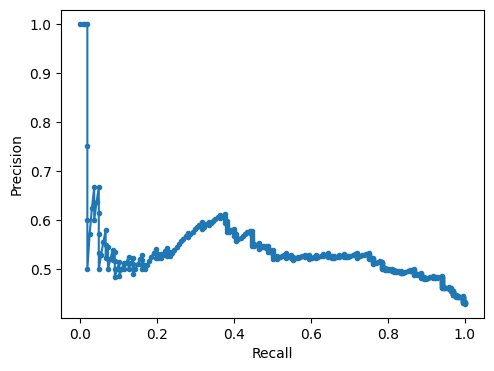

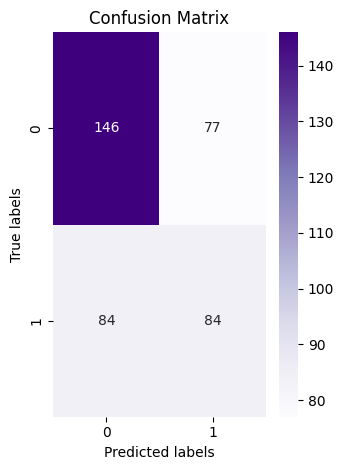

In [ ]:
modelf.ModelSelection_Summary(xgb_model1)

In [ ]:
import pickle

file_path = '/content/drive/MyDrive/Data/Dissertation_Data/xgb_model1.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(xgb_model1, file)


Hyperparameter-Tuning: Round 2

In [ ]:
param_grid2 = dict(
    FS__threshold = ["mean", "median"],
    FS__n_features_to_select = [10, 20],
    classifier__n_estimators = [200, 400, 500],
    classifier__max_depth = [3, 5],
    classifier__learning_rate = [0.01, 0.1, 0.5],
    classifier__subsample = [0.5, 0.8],
    classifier__colsample_bytree = [0.5, 0.8])

# model 2
xgb_spec2 = {
    'df': prep1_df,
    'target': 'ReliableRecovery',
    #'selector': 'SelectFromModel',
    'selector': 'RFE',
    'param_grid': param_grid1,
    'outer_k': 10,
    'inner_k': 5}

xgb_model2 = modelf.XGBoost_ModelSelection(**xgb_spec2)

## Modelling

In [ ]:
# machine learning models
from xgboost import XGBClassifier

# feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

# hyperparameter-tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# evaluation
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

In [ ]:
def XGBoost_Training(df, target, selector, param_grid, k=5, print=True):

    # dataset
    sample = df.dropna(subset = [target])
    EndDesc_cols = [col for col in df.columns if 'EndDesc' in col] #EndDescShort_cols = [col for col in df.columns if 'EndDescShort' in col] # none
    X = sample.drop(['ReliableChangeDesc', 'ReliableRecovery', 'Recovery'] + EndDesc_cols, axis = 1)
    y = sample[target]
    cols = X.columns

    # machine learning algorithm
    classifier = XGBClassifier()

    # feature selection method
    if selector == 'SelectFromModel':
        selector = SelectFromModel(classifier)
    elif selector == 'RFE':
        selector = RFE(classifier)
    else:
        # fill this #
        raise ValueError('Unsupported selector type')

    # pipeline
    pipeline = Pipeline([("FS", selector), ("classifier", classifier)])

    # initialise lists
    scores, preds, actuals = [], [], []

    # cross validation and hyperparameter tuning
    outer_cv = StratifiedKFold(n_splits = k, shuffle = True)
    for train_index, test_index in outer_cv.split(X, y):

        # outer CV train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # fit data
        pipeline.fit(X_train, y_train)

        # evaluating optimised model on test
        predictions = pipeline.predict(X_test)
        score = metrics.accuracy_score(y_test, predictions)
        scores.append(score)
        #print('Accuracy: {}'.format(score)) # test sets

        probs = pipeline.predict_proba(X_test)[:, 1]
        preds.extend(probs)
        actuals.extend(y_test)

    if print == False:
        pass
    else:
        print('Overall accuracy: {}'.format(np.mean(scores))) # test sets
        print("--------------------------------------------------")

    return scores, preds, actuals


In [ ]:
def xgb_grid(params_str):
    params = params_str.split(', ')
    param_grid = {
        'FS__threshold': params[0],
        'classifier__max_depth': int(params[1]) if params[1] != 'None' else None,
        'classifier__n_estimators': int(params[2]) if params[2] != 'None' else None,
        'classifier__learning_rate': float(params[3]) if params[3] != 'None' else None,
        'classifier__min_child_weight': float(params[4]) if params[4] != 'None' else None,
        'classifier__subsample': float(params[5]) if params[5] != 'None' else None,
        'classifier__colsample_bytree': float(params[6]) if params[6] != 'None' else None,
        'classifier__gamma': float(params[7]) if params[7] != 'None' else None,
        'classifier__reg_lambda': float(params[8]) if params[8] != 'None' else None,
        'classifier__reg_alpha': float(params[9]) if params[9] != 'None' else None
    }
    return param_grid

In [ ]:
param_gridA = xgb_grid('10, 5, 200, 0.1, None, 0.5, 0.5, None, None, None')
param_gridB = xgb_grid('50, 5, 200, 0.1, None, 0.5, 0.5, None, None, None')
param_gridC = xgb_grid('10, 5, 400, 0.01, None, 0.5, 0.8, None, None, None')
param_gridD = xgb_grid('50, 5, 400, 0.01, None, 0.5, 0.8, None, None, None')

param_grids = [param_gridA, param_gridB, param_gridC, param_gridD]

In [ ]:
for index, param_grid in enumerate(param_grids):
    xgb_spec = {
        'df': prep1_df,
        'target': 'ReliableRecovery',
        #'selector': 'SelectFromModel',
        'selector': 'RFE',
        'param_grid': param_grid,
        'k': 10}

        XGBoost_Training(**xgb_spec)

Overall accuracy: 0.6342307692307693
--------------------------------------------------
Overall accuracy: 0.634423076923077
--------------------------------------------------


## Modelling 2

In [ ]:
data, raw_df = cleanf.load_data()
data = cleanf.Clean_Data(data)

import itertools

prep_grid = dict(
    df=[data],
    quasi_thresh=[0.995, 0.999],
    corr_thresh=[0.95, 0.99],
    load_matrices=[True],
    col_thresh=[0.3, 0.35, 0.4, 0.45],
    row_thresh=[0.2, 0.5],
    scale_method=['normalise'],
    imputation_method=['iterative'],
    #n_neighbours=[5],
    max_iter=[5],
    k_features=[100, 200]
)

# Create all combinations of parameters
keys, values = zip(*prep_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Create instances of Prepare_Data for each combination
prep_dfs = []
for params in combinations:
    prep_df = prepf.Prepare_Data(
        df=params['df'],
        quasi_thresh=params['quasi_thresh'],
        corr_thresh=params['corr_thresh'],
        load_matrices=params['load_matrices'],
        col_thresh=params['col_thresh'],
        row_thresh=params['row_thresh'],
        scale_method=params['scale_method'],
        imputation_method=params['imputation_method'],
        #n_neighbours=params['n_neighbours'],
        max_iter=params['max_iter'],
        k_features=params['k_features'])
    prep_dfs.append(prep_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for i, prep_df in enumerate(prep_dfs):
    name = f'prep{i+1}_df'  # Generate a name for each dataframe
    cleanf.manage_data(prep_df, name, 'save')

Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!


In [ ]:
# decent hyperparameters
param_gridA = xgb_grid('10, 5, 200, 0.1, None, 0.5, 0.5, None, None, None')
param_gridB = xgb_grid('50, 5, 200, 0.1, None, 0.5, 0.5, None, None, None') # changed to 50
param_gridC = xgb_grid('10, 5, 400, 0.01, None, 0.5, 0.8, None, None, None')
param_gridD = xgb_grid('50, 5, 400, 0.01, None, 0.5, 0.8, None, None, None')
param_gridE = xgb_grid('10, 10, 400, 0.05, None, 0.5, 0.8, None, None, None') # new
param_gridF = xgb_grid('10, 10, 400, 0.05, None, 0.5, 0.8, None, None, None')

param_grids = [param_gridA, param_gridB, param_gridC, param_gridD, param_gridE, param_gridF]

for i, prep_df in enumerate(prep_dfs):
    print(f'Preparation data: {i + 1}')
    for i, param_grid in enumerate(param_grids):
        xgb_spec = {
            'df': prep_df,
            'target': 'ReliableRecovery',
            #'selector': 'SelectFromModel',
            'selector': 'RFE',
            'param_grid': param_grid,
            'k': 5,
            'print': False}

        scores = XGBoost_Training(**xgb_spec)[0]
    print(f'Overall accuracy: {np.mean(scores)}')
    print(f'Deviation of accuracy: {np.std(scores)}')
    print('--------------------------------------------------')

Preparation data: 1
Overall accuracy: 0.5372281726712107
Deviation of accuracy: 0.03344812571721832
--------------------------------------------------
Preparation data: 2
Overall accuracy: 0.5422590068159688
Deviation of accuracy: 0.05465468756929363
--------------------------------------------------
Preparation data: 3
Overall accuracy: 0.6264199935086011
Deviation of accuracy: 0.037172115976768144
--------------------------------------------------
Preparation data: 4
Overall accuracy: 0.6136319376825706
Deviation of accuracy: 0.05795417906154838
--------------------------------------------------
Preparation data: 5
Overall accuracy: 0.5703018500486855
Deviation of accuracy: 0.025538808331445256
--------------------------------------------------
Preparation data: 6
Overall accuracy: 0.5319376825705939
Deviation of accuracy: 0.025585171644815174
--------------------------------------------------
Preparation data: 7
Overall accuracy: 0.6418370658876988
Deviation of accuracy: 0.030327409